# Assignment 2 - Monte Carlo

In this assignment, you will develop a model of experimental outcomes which you will use to interpret the results of an experiment.

In each part of this assignment, you will be asked to write some code in the cell indicated.  If you find it convenient to break your code up over multiple cells, please do so.  You will also be asked to briefly discuss your code and results obtained in a text cell.

You should use numpy and scipy libraries where appropriate. You will always be told explicitly if you should **not** use a particular library.  Make sure to comment your code.  Make sure all cells run from a freshly opened notebook before you submit your work.

## Part 1 - Generating a Gaussian Distribution

In this part of the assignment, we will explore a method for generating random numbesr with a Gaussian probability distribution function.

$$ f(x|\mu) = \frac{1}{\lambda \sqrt{2 \pi}}e^\frac{-(x-\mu)^2}{2\lambda^2}$$

Unfortunately the Gaussian cumulative distribution function is not analytically invertible. However, there are a number of alternative transformations in use. One such example is the Box-Muller transformation, which relies on generating _two_ random numbers, $u$ and $v$, each in the range $(0,1)$. It can then be shown that :

$$z = \sqrt{-2\ln{u}} \cos{2 \pi v}$$

has a Gaussian distribution with mean $\mu=0$ and standard deviation $\lambda=1$.

You should implement a function that will generate random values, distributed according to a Gaussian with user-definable mean $\mu$ and standard deviation $\lambda$ (ie. set via arguments).  You should verify that your function does indeed produce a Gaussian distribution for a selection of $\mu$ and $\lambda$.

Enter the mean 
4.8
Enter the std 
0.5


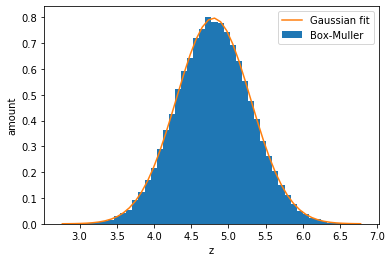

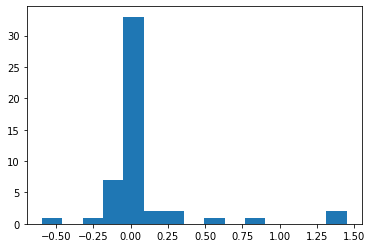

Box-Muller: residual mean = 6.58e-02, std dev = 3.24e-01


In [14]:
import numpy.random as random
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

#Asks for user inputs
m_input = input("Enter the mean \n")
s_input = input("Enter the std \n")

#Converts to float values
m = float(m_input)
s = float(s_input)
#Validates standard deviation
while s <= 0:
    print("Invalid deviation")
    s_input = input("Please enter a std which is greater than 0 \n")
    s = float(s_input)

#Box muller function
def BoxMullerAR(mean,standarddeviation):
    u = random.random()
    v = random.random()
    z = np.sqrt(-2 * np.log(u)) * np.cos(2*np.pi*v)
    return z*standarddeviation + mean

#Gauss plot reference
def gauss(x,m,s):
    return 1/(s*np.sqrt(2*np.pi)) * np.exp(-(x-m)**2/(2*s**2))


#Plots box muller for a range of random values
BMvalues = [BoxMullerAR(m,s) for _ in range(50000)]
boxhist, boxbins, boxpatches = plt.hist(BMvalues, bins=50, density=True, label="Box-Muller")

#Bin centres are found and used for gaussian plot
bin_centres = (boxbins[1:] + boxbins[:-1])/2
plt.plot(bin_centres, gauss(bin_centres,m,s) , label="Gaussian fit")

plt.xlabel(r'z')
plt.ylabel(r'amount')
plt.legend()
plt.show()

#Plot residuals
res = boxhist/gauss(bin_centres,m,s) - 1
histres, binres, patchres = plt.hist(res, bins=15, label="analytic")
plt.show()

print("Box-Muller: residual mean = {0:.2e}, std dev = {1:.2e}".format(np.mean(res), np.std(res)))


**Discuss your results in this cell**

## Part 2 - Upper Limit in a Counting Experiment

A "counting experiment" is performed at a collider, to search for the existence of a hypothesised new particle.  The experiment consists of counting the number of events that meet certain criteria. Events can be produced either by the hypothetical signal process, or by known background processes. However, an individual event cannot be ascribed to be signal or background - the only measurable quantity is the _total_ number of events.

Both signal and background processes produce a number of events that is Poisson distributed. The mean number of background events has been estimated to be $4.8 \pm 0.5$.  The mean number of signal events is given by $L \sigma$, where the integrated luminosity $L=10 \pm 0.3 {\rm nb}^{-1}$, and $\sigma$ is the (unknown) cross section of the signal process. The number of events observed in the real experiment is 6.

You should write a Monte Carlo programme that will calculate an upper limit on the signal cross section, that is compatible with the observation at 95% confidence level.  In order to do this you will need to :
* build a model of the experiment and its uncertainties that you can use to generate pseudo-experiments
* model signal and background as separate Poisson processes
* model all other uncertainties as Gaussian distributed
* scan hypotheses for $\sigma$ and generate probability distributions for the observed event counts for each hypothesis
* compare the PDFs of observed event counts, with the real experiment, to find the upper limit on $\sigma$

An upper limit is a one-sided confidence interval, since the lower bound is always zero.  It differs from a two-sided confidence interval, where an equal fraction of pseudo experiments are found above and below the interval.  The upper limit can be defined as the value of $\sigma$ for which 95% of pseudo-experiments give a result greater than that observed in the real experiment.

First use your model to calculate the upper limit on $\sigma$ that can be inferred from the real experiment, in which 6 events were observed.

Next, consider that a theoretical prediction gives $\sigma = 0.1 {\rm nb}$.  What integrated luminosity would need to be accumulated in order to probe this cross-section at the 95% confidence level?  Assume the mean background scales linearly with luminosity.  You should also calculate an "expected upper limit", which is the limit obtained if the number of observed events equals the mean background.  Perform the calculation for two different assumptions about the uncertainties : 
1. a conservative assumption that the relative uncertainty is fixed (as given above)
2. an optimistic assumption that the relative uncertainty will scale proportional to $L^{-1/2}$

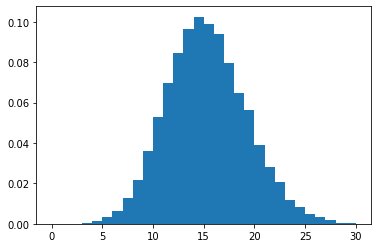

In [58]:

#Produces a poisson distribution from a given sigma
def TotalCount(sigma):

    backgroundmean = np.random.normal(4.8,0.5)
    backgroundvalue = np.random.poisson(backgroundmean)

    signalmean = np.random.normal(10,0.3) * sigma
    signalvalue = np.random.poisson(signalmean)

    total = signalvalue + backgroundvalue
    
    return total

Tvalues = [TotalCount(1) for _ in range(10000)]
Thist, Tbins, boxpatches = plt.hist(Tvalues, bins=30, range=[0,30.0] , density=True)
plt.show()

# fraction of a histogram above a given value
def fAbove(hist, bins, x0):
    i = np.searchsorted(bins, x0)
    return np.sum(hist[i::1])

# fraction of a histogram below a given value x0
def fBelow(hist, bins, x0):
    i = np.searchsorted(bins, x0)
    return np.sum(hist[:i:1])

# find value of f_below that matches alpha and return array index
def thetaLow(f_aboves, alpha):
    
    # np.searchsorted will find the position where a value should be inserted to preserve the order
    # add one gives the first bin which is greater than alpha
    i = np.searchsorted(f_aboves, alpha)
    return i

# find value of f_above that matches alpha and return array index
def thetaHigh(f_belows, alpha):
    
    # searchsorted expects an array in ascending order
    tmp = np.sort(f_belows)
    
    # now we can do the same as before
    i = np.searchsorted(tmp, alpha)
    
    # but return the correct index of the original array
    return len(tmp)-i






**Discuss your results in this cell**